In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet 

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import gensim

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound


#for sentiment analysis
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import sentiment as sent

[nltk_data] Downloading package wordnet to /home/traffic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/traffic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/traffic/.local/lib/python3.8/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
2022-05-12 20:25:10.071642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 20:25:10.071702: I tensorflow/

In [2]:
import importlib
importlib.reload(sent)

<module 'sentiment' from '/home/traffic/code/App_Sentiment_plot/sentiment.py'>

In [3]:
## authenticate with BigQuery API
credentials = service_account.Credentials.from_service_account_file(
    '../../datascience-abovezero-58d98dcf7f65.json')
client = bigquery.Client.from_service_account_json(
    '../../datascience-abovezero-58d98dcf7f65.json')
# Perform a query.
QUERY = ('SELECT * FROM `datascience-abovezero.ml_sandbox.chegg_influencers_comments`')
query_job = client.query(QUERY)  # API request
df =  query_job.result().to_dataframe() #transform to Pandas Dataframe

#df2 = pd.read_csv('analisis_comments_tiktok.csv')# Parameters tuning using Grid Search

# Settings

In [4]:
### settings for topic analysis

N_COMPONENTS = 4 #number of topics



### settings for sentiment analysis

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 1

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# 1. Topic Analysis

## Bag Of Words

### Preprocessing 

In [5]:
#def spelling_correcter(text):
    
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

comments = df.comment.tolist()
comments_prep = [preprocess(str(comment)) for comment in comments]
comments_dict = gensim.corpora.Dictionary(comments_prep)
bow_corpus = [comments_dict.doc2bow(doc) for doc in comments_prep]

## TFIDF 

### Preprocessing

In [6]:
#### docs_raw = df.comment.fillna('').tolist()

tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 0.01)
#dtm_tf = tf_vectorizer.fit_transform(docs_raw)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
#dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)

### Training The Model 

In [7]:
def get_top_topics(model, vectorizer, topn=5):
    names = tf_vectorizer.get_feature_names()
    res = {}
    for i_cluster, cluster in enumerate(model.components_):
        res[i_cluster]=[]
        for i_feature in cluster.argsort()[:-topn - 1:-1]:
            res[i_cluster] = res[i_cluster] + [names[i_feature]]
    return res

## first get topics for all comments (Full Dataset)
docs_raw_full = df.comment.fillna('').tolist()
dtm_tf_full = tf_vectorizer.fit_transform(docs_raw_full)
# train model to find topics per influencer
lda_tf_full = LatentDirichletAllocation(n_components=N_COMPONENTS, random_state=0)
lda_tf_full.fit(dtm_tf_full)
# extract most important topics
topics_full =  get_top_topics(lda_tf_full, tf_vectorizer, topn=5)
print(topics_full)

X_test = tf_vectorizer.transform(df.loc[:,'comment'])

doc_topic_dist_unnormalized_full = np.matrix(lda_tf_full.transform(X_test))

/home/traffic/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['school', 'thank', 'quot', 'like', 'high'], 1: ['cancer', 'colon', 'youtube', 'amp', 'literally'], 2: ['love', 'cancer', 'simone', 'colon', 'year'], 3: ['video', 'life', 'just', 'like', 'time']}


### Scoring the data

In [24]:
#first get topics for all comments (Full Dataset)
docs_raw_full = df.comment.fillna('').tolist()
dtm_tf_full = tf_vectorizer.fit_transform(docs_raw_full)
# train model to find topics per influencer
lda_tf_full = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf_full.fit(dtm_tf_full)
# extract most important topics
topics_full =  get_top_topics(lda_tf_full, tf_vectorizer, topn=5)


/home/traffic/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
res_infl.head()

influencer     0     1     2     3  likesrel_0  likesrel_1  \
0         itssozer  59.2   8.2  14.3  18.4    0.722222    0.006944   
1       emilyballz  73.7   5.3  15.8   5.3    0.789474    0.157895   
2  iamalilstitious  50.0   0.0  37.5  12.5    0.666667    0.000000   
3       sarahbada_  73.7   5.3  15.8   5.3    0.913043    0.000000   
4     sakshammagic  73.1  11.5   3.8  11.5    0.761905    0.142857   

   likesrel_2  likesrel_3  likestot_0  likestot_1  likestot_2  likestot_3  
0    0.243056    0.027778         104           1          35           4  
1    0.000000    0.052632          15           3           0           1  
2    0.333333    0.000000           2           0           1           0  
3    0.086957    0.000000          21           0           2           0  
4    0.000000    0.095238          16           3           0           2

# 2. Sentiment

### Loading Pre-trained Model + creating Datasets for Training

In [11]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
global model
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)





# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = sent.Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

print('Dealing with Training Data...')
# Create pytorch dataset.
train_dataset = sent.MovieReviewsDataset(path='/home/traffic/data/aclImdb/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = sent.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation Data...')
# Create pytorch dataset.
valid_dataset =  sent.MovieReviewsDataset(path='/home/traffic/data/aclImdb/test', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = sent.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`
Dealing with Training Data...


pos files:   0%|          | 0/12500 [00:00<?, ?it/s]

neg files:   0%|          | 0/12500 [00:00<?, ?it/s]

Created `train_dataset` with 25000 examples!
Created `train_dataloader` with 782 batches!

Dealing with Validation Data...


pos files:   0%|          | 0/12500 [00:00<?, ?it/s]

neg files:   0%|          | 0/12500 [00:00<?, ?it/s]

Created `valid_dataset` with 25000 examples!
Created `eval_dataloader` with 782 batches!


### Training

In [13]:
importlib.reload(sent)

<module 'sentiment' from '/home/traffic/code/App_Sentiment_plot/sentiment.py'>

Epoch


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.50429 - val_loss: 0.39342 - train_acc: 0.75168 - valid_acc: 0.81276



/home/traffic/.local/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


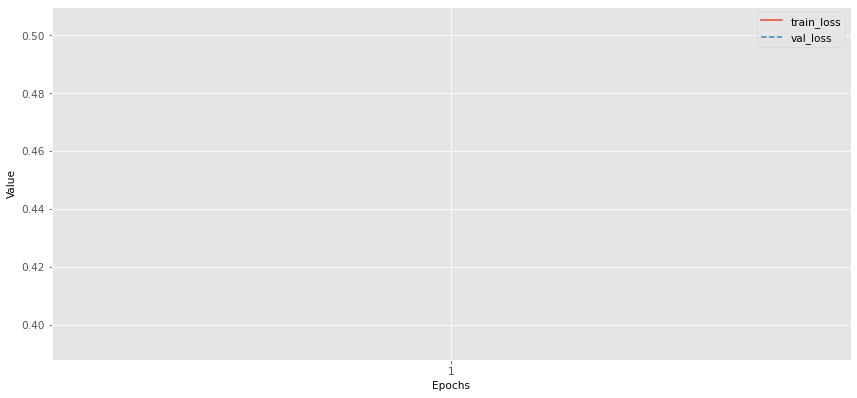

/home/traffic/.local/lib/python3.8/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


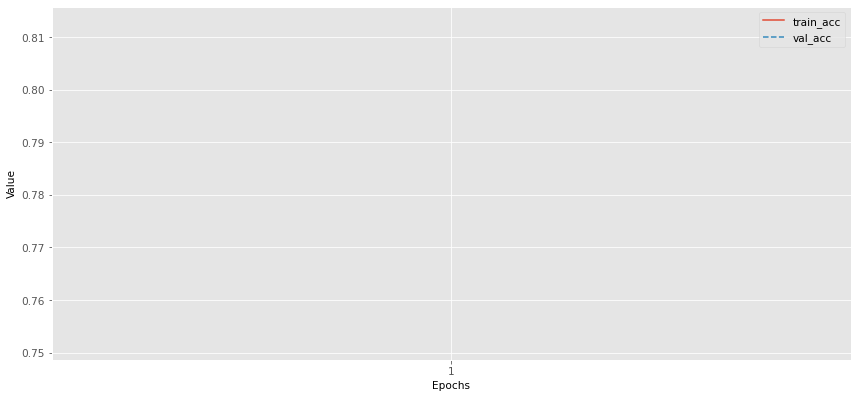

In [14]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = sent.train(train_dataloader, optimizer, scheduler, device, model)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = sent.validation(valid_dataloader, device, model)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Performance Evaluation

In [18]:
print('sers')

sers


  0%|          | 0/782 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.81      0.82      0.81     12500
         pos       0.82      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Normalized confusion matrix


/home/traffic/.local/lib/python3.8/site-packages/ml_things/plot_functions.py:722: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


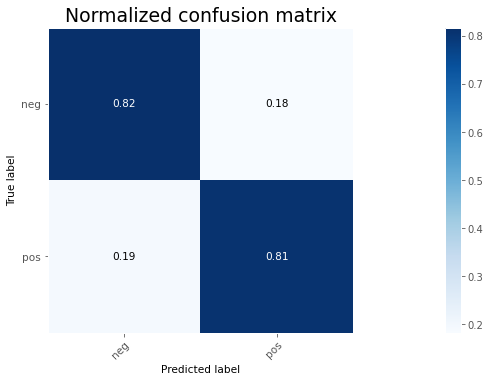

In [17]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = sent.validation(valid_dataloader, device, model)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

## Applying Model to our Data

In [19]:
#df = pd.read_csv('analisis_comments_tiktok.csv')
comments = [str(comment) for comment in df.comment.fillna('').tolist()]
chegg_dataset = sent.CheggDataset(df=comments, use_tokenizer=tokenizer)

chegg_dataloader = sent.DataLoader(chegg_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

_, predictions_labels, _ = sent.validation(chegg_dataloader, device, model)

results = pd.DataFrame({'comments':comments,'labels':predictions_labels})
results
df_sentiment = df.copy()
df_sentiment['labels'] = predictions_labels
df_sentiment.to_csv('../../data/df_sentiment.csv',index=False)

  0%|          | 0/112 [00:00<?, ?it/s]

NameError: name 'prediction_labels' is not defined

## Arranging the Result

In [31]:
#now let's what of those topics are talked about by what influencer
# and then go more granular and look at topics on influencer level.
topic_mapping = pd.DataFrame()
res_infl = pd.DataFrame({'influencer':[]})
for topic in topics_full:
    topic_mapping.loc[:,topic] = np.array([str(topics_full[topic])])
    res_infl[topic] = []
    
for topic in topics_full:
    res_infl['likesrel_'+str(topic)] = []
for topic in topics_full:
    res_infl['likestot_'+str(topic)] = []
    
for topic in topics_full:
    res_infl['positiverel_'+str(topic)] = []

for i_infl, infl in enumerate(df_sentiment.influencer.unique()):
    dfi = df_sentiment.loc[df_sentiment.influencer==infl,:]
    #what categories of full topic model do infl comments belong to
    X_test = tf_vectorizer.transform(dfi.loc[:,'comment'])
    doc_topic_dist_unnormalized_full = np.matrix(lda_tf_full.transform(X_test))
    # get count of number topics are 'hit'
    res_ = pd.DataFrame({'topic':list(topics_full.keys())})
    
    res__ = pd.DataFrame(doc_topic_dist_unnormalized_full.argmax(axis=1)).value_counts().rename_axis('topic').reset_index(name='counts')
    res_ = res_.merge(res__, on='topic', how='left').reset_index(drop=True).fillna(0)
    
    # calculate relative topic distribution for influencer
    counts_sum = res_.counts.sum()
    res_.loc[:,'counts'] = res_.counts.apply(lambda x:round(x/counts_sum*100,1))
    res_ = res_.sort_values('topic',ascending=True).reset_index(drop=True)
    
    l_likecount_tot = len(topics_full)*[0]
    total_likecount = dfi.comment_likecount.sum()
    l_poscomments_tot = len(topics_full)*[0]
    total_comments_pertopic = len(topics_full)*[0]
    for comment, comment_orig, comment_likes, comment_label in zip(doc_topic_dist_unnormalized_full, dfi.comment, dfi.comment_likecount, dfi.labels):
        l_likecount_tot[comment[0].argmax()]+=comment_likes
        l_poscomments_tot[comment[0].argmax()]+=comment_label
        total_comments_pertopic[comment[0].argmax()]+=1


    l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
    l_poscomments_rel = [(v/n if n>0 else 0) for v, n in zip(l_poscomments_tot, total_comments_pertopic)]
    res_infl.loc[len(res_infl)] = [infl] + list(res_.counts) + l_likecount_rel + l_likecount_tot + l_poscomments_rel
 
    """  
    docs_raw = dfi.comment.fillna('').tolist()
    dtm_tf = tf_vectorizer.fit_transform(docs_raw)
    # train model to find topics per influencer
    lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
    lda_tf.fit(dtm_tf)d
    # extract most important topics
    topics =  get_top_topics(lda_tf, tf_vectorizer, topn=5)
    print(infl)
    print(topics)
    
    doc_topic_dist_unnormalized = np.matrix(lda_tf.transform(X_test))
    for comment, comment_orig in zip(doc_topic_dist_unnormalized, dfi.comment):
        print(comment_orig)
        print(topics[comment[0].argmax()])
    """
    #if i_infl>-1:
    #    break

/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]
/tmp/ipykernel_6198/2189566469.py:43: RuntimeWarning: invalid value encountered in long_scalars
  l_likecount_rel = [v/total_likecount for v in l_likecount_tot]


In [33]:
res_infl.head(20)

influencer      0     1     2     3  likesrel_0  likesrel_1  \
0               itssozer   59.2   8.2  14.3  18.4    0.722222    0.006944   
1             emilyballz   73.7   5.3  15.8   5.3    0.789474    0.157895   
2        iamalilstitious   50.0   0.0  37.5  12.5    0.666667    0.000000   
3             sarahbada_   73.7   5.3  15.8   5.3    0.913043    0.000000   
4           sakshammagic   73.1  11.5   3.8  11.5    0.761905    0.142857   
5                cloutom   74.7   5.3  13.3   6.7    0.932836    0.022388   
6             medstudebt   40.0   0.0  40.0  20.0    0.125000    0.000000   
7            j0siahyoung   90.0   0.0  10.0   0.0    0.833333    0.000000   
8     modern.day.classic   70.8   6.2  16.9   6.2    0.960000    0.000000   
9               sarahrav   69.6   6.5  13.0  10.9    0.769231    0.000000   
10    ryanmarksutherland   59.0  20.0  11.0  10.0    0.330258    0.143911   
11           themccartys   77.1   2.1   7.9  12.9    0.460560    0.007634   
12           espdaniella   68.8   3.1  12.5  15.6    0.517241    0.017241   
13  thatrelatablestudent   76.7   5.0  11.7   6.7    0.791332    0.033708   
14           niki_patton   57.5   8.2  28.8   5.5    0.677419    0.000000   
15        thelawerangela   67.4   6.5   6.5  19.6    0.807229    0.060241   
16         lifeincollege  100.0   0.0   0.0   0.0         NaN         NaN   
17          rrogersworld   59.2  10.2  20.4  10.2    0.401869    0.000000   
18          lexistrechak   67.4  16.3  11.1   5.2    0.574713    0.061303   
19         maddyspencer5   88.2   0.0   5.9   5.9    0.882353    0.000000   

    likesrel_2  likesrel_3  likestot_0  likestot_1  likestot_2  likestot_3  \
0     0.243056    0.027778         104           1          35           4   
1     0.000000    0.052632          15           3           0           1   
2     0.333333    0.000000           2           0           1           0   
3     0.086957    0.000000          21           0           2           0   
4     0.000000    0.095238          16           3           0           2   
5     0.022388    0.022388         125           3           3           3   
6     0.750000    0.125000           1           0           6           1   
7     0.166667    0.000000           5           0           1           0   
8     0.040000    0.000000          24           0           1           0   
9     0.076923    0.153846          20           0           2           4   
10    0.225092    0.300738         179          78         122         163   
11    0.307888    0.223919         181           3         121          88   
12    0.465517    0.000000          30           1          27           0   
13    0.049759    0.125201         493          21          31          78   
14    0.161290    0.161290          42           0          10          10   
15    0.012048    0.120482          67           5           1          10   
16         NaN         NaN           0           0           0           0   
17    0.065421    0.532710          43           0           7          57   
18    0.268199    0.095785         150          16          70          25   
19    0.000000    0.117647          15           0           0           2   

    positiverel_0  positiverel_1  positiverel_2  positiverel_3  
0        0.137931       0.250000       0.142857       0.333333  
1        0.285714       0.000000       0.000000       1.000000  
2        0.000000       0.000000       0.333333       0.000000  
3        0.071429       0.000000       0.000000       0.000000  
4        0.263158       0.333333       0.000000       0.000000  
5        0.214286       0.500000       0.000000       0.200000  
6        0.000000       0.000000       0.000000       0.000000  
7        0.222222       0.000000       0.000000       0.000000  
8        0.304348       0.250000       0.545455       0.500000  
9        0.125000       0.333333       0.500000       0.200000  
10       0.101695       0.200000       0.0

## Write Results to BigQuery

In [36]:
def save_results(df, table_id="datascience-abovezero.ml_sandbox.chegg_influencers_comments_results"):
    # create BigQuery table if it doesn't already exist
    try: 
        client.get_table(table_id)  # Make an API request.
        print("Table {} already exists.".format(table_id))
    except NotFound:
        print(f"Table {table_id} created.")
        schema = [
            bigquery.SchemaField("influencer", "STRING", mode="REQUIRED"),
            bigquery.SchemaField('_'.join(['topic0'] + topics_full[0]), "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('_'.join(['topic1'] + topics_full[1]), "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('_'.join(['topic2'] + topics_full[2]), "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('_'.join(['topic3'] + topics_full[3]), "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likesrel0', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likesrel1', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likesrel2', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likesrel3', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likestot0', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likestot1', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likestot2', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('likestot3', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('positiverel0', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('positiverel1', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('positiverel2', "FLOAT64", mode="REQUIRED"),
            bigquery.SchemaField('positiverel3', "FLOAT64", mode="REQUIRED"),
        ]
        table = bigquery.Table(table_id, schema=schema)
        table = client.create_table(table)  # Make an API request.
        #print(
        #    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
        #)
    df.columns = ['influencer', '_'.join(['topic']+topics_full[0]),'_'.join(['topic']+topics_full[1]),'_'.join(['topic']+topics_full[2]),'_'.join(['topic']+topics_full[3]),
                 'likesrel0','likesrel1','likesrel2','likesrel3','likestot0','likestot1','likestot2','likestot3',
                 'positiverel0','positiverel1','positiverel2','positiverel3']     
    df.to_gbq('.'.join(table_id.split('.')[1:]), project_id=table_id.split('.')[0], if_exists='replace',#'append',
          chunksize=10000, progress_bar=True, credentials=credentials)

    
save_results(res_infl)

Table datascience-abovezero.ml_sandbox.chegg_influencers_comments_results already exists.


/home/traffic/.local/lib/python3.8/site-packages/pandas/io/gbq.py:212: DeprecationWarning: chunksize is ignored when using api_method='load_parquet'
  pandas_gbq.to_gbq(
100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5005.14it/s]
